# EDS Data Processing (Post-NMF)

This is intended as an example notebook showing the data processing steps required for EDS data after NMF: eg. mask extraction and CSD plots. It's probably best to become familiar with Hyperspy before using this notebook - https://hyperspy.readthedocs.io/en/stable/user_guide/index.html. 

In [1]:
#use '%matplotlib qt' to get outputs in separate window
%matplotlib inline


#import all necessary libraries/modules
import hyperspy.api as hs
import hyperspy

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import numpy as np

import skimage as ski
from skimage import morphology, measure
from skimage.feature import peak_local_max

from scipy import ndimage as ndi

#import .py scripts containing necessary functions (present in folder)
import Approx_CSD_generators as csd
import Useful_funcs as u_func

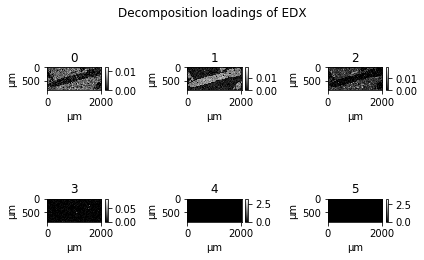

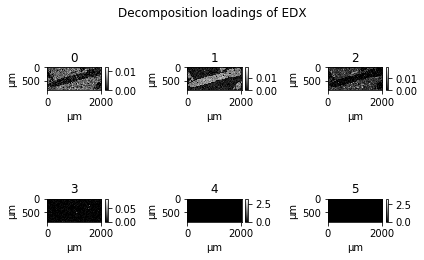

In [2]:
#load data which includes all the machine learning results
data = hs.load("Data/JM1_OL6_map1_decomp.hspy", lazy = True)

#note lazy loading is used to store the data in 'chunks' so as to reduce RAM usage significantly 
#(lot of these files would require 20GB+)
#lazy mode uses Dask by default in hyperspy which doesn't change a lot of things, apart from having to use
#the '.compute()' command when you want something to be executed. 
#More info here: https://hyperspy.readthedocs.io/en/stable/user_guide/big_data.html
#And here: https://docs.dask.org/en/latest/


#plot results
data.plot_decomposition_loadings()

It's clear that components 0, 1, 2 and 3 are the four distinct phases present here; plotting them separately below:

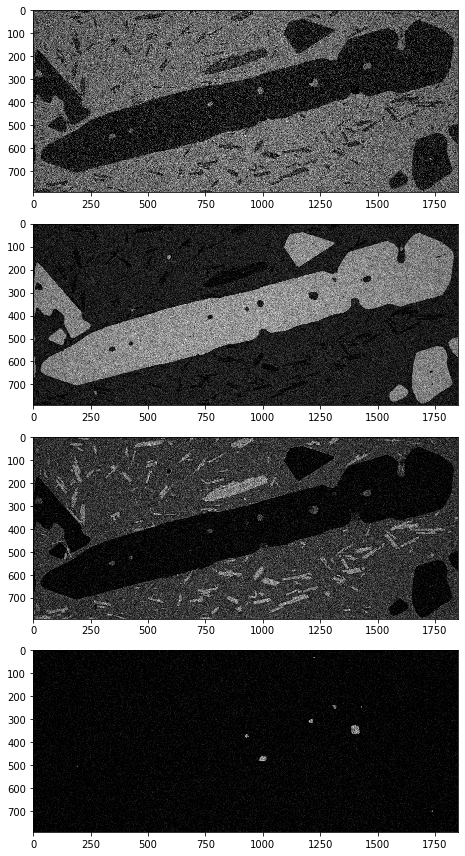

In [3]:
phases = [0,1,2,3]
components = data.get_decomposition_loadings()
loads, ax = plt.subplots(len(phases), 1, figsize =(8,12))

for i in range(len(phases)):
    #.compute() is required below due to lazy loading of data
    ax[i].imshow(components.inav[phases[i]].data.compute())
    
loads.tight_layout()

The different factors may be identified a similar way.

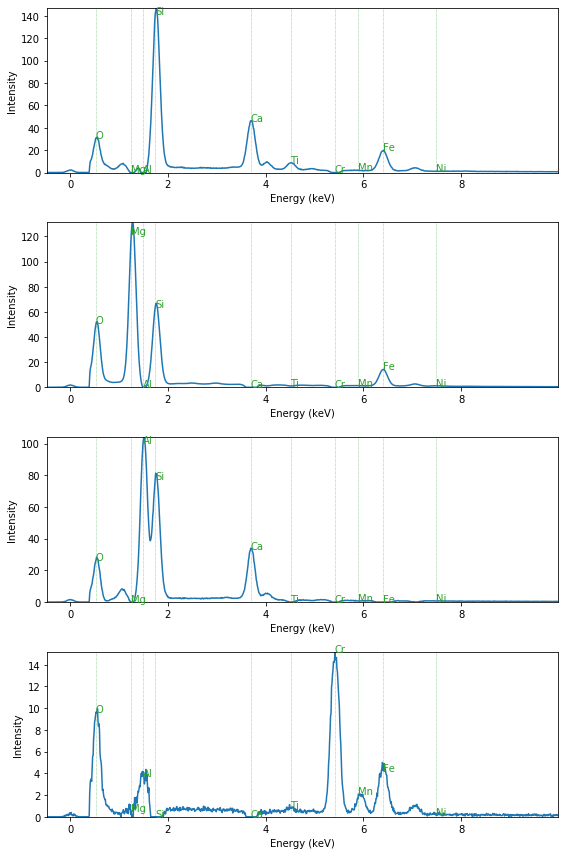

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [4]:
factors = data.get_decomposition_factors()

#obtain list of all elements identified during EDS scanning these elements are saved along with .bcf files.
elements = data.metadata.Sample.elements
#get all energies from Hyperspy database
element_energy = [(hs.material.elements[i].Atomic_properties.Xray_lines.Ka['energy (keV)']) for i in elements]

spectra, ax = plt.subplots(len(phases), 1, figsize =(8,12))

for i in range(len(phases)):
    #plots spectra/component up to 10KeV energy (can be changed)
    hyperspy.drawing.utils.plot_spectra(factors.inav[phases[i]].isig[:10.0], ax = ax[i])

    #Label each element to the correct part of the spectra (requires further work to make it aesthetically pleasing)
    for n in range(len(elements)):
        y = factors.inav[phases[i]].isig[element_energy[n]].data
        ax[i].axvline(element_energy[n], c='C2', ls=':', lw=0.5)
        ax[i].text(x=element_energy[n], y=y, s=elements[n], color='C2')

spectra.tight_layout()

In [5]:
#Figures may be saved easily using the below commands (or modified versions)

loads.savefig("name here", dpi = 600)
spectra.savefig("name here", dpi = 600)

## Mask extraction

The above are not yet in their most useful form - they need to be converted to 'binary images': images of only 1s and 0s. This can be done manually by setting a suitable threshold below which all pixels are 0 and 1 above or automatically by using a suitable algorithm - eg. Otsu's method (https://en.wikipedia.org/wiki/Otsu%27s_method and https://scikit-image.org/docs/0.7.0/api/skimage.filter.thresholding.html).

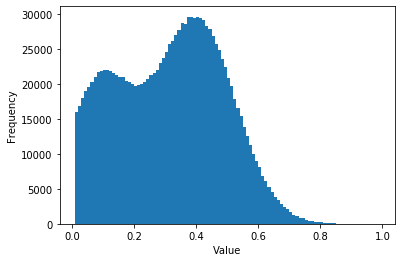

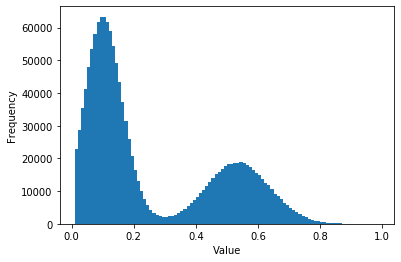

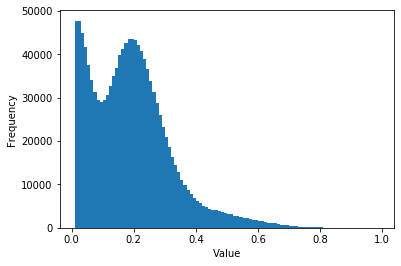

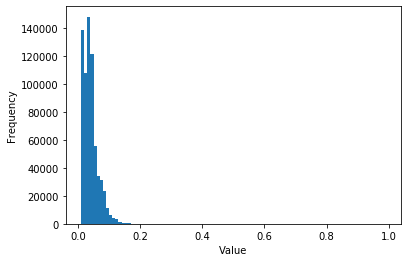

In [6]:
phase_images = []

for i in phases:
    #.compute() is required below due to lazy loading of data
    image = components.inav[i].data.compute().copy()
    image = image/image.max() #normalize loading values
    
    phase_images.append(image)
    
    #creating bins from 0.01 to 1 with width 0.01.
    bins = [0.01*(n+1) for n in range(99)]
    
    fig, ax = plt.subplots()
    ax.hist(image.flatten(), bins)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    

Most histograms above show a clear bimodal distribution of loadings in each image so thresholding is faily simple - choose value in trough between two peaks. This is also ideal for Otsu's method to be used too as it was made for such data. For the third image however, this is not true (due to compositional similarity of Plag and glass) so it will be a lot harder and 'multi_otsu' thresholding is required if automatic method is used. Images can be post-processed to get rid of noise so they don't have to (and never will) look perfect.

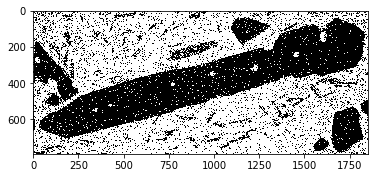

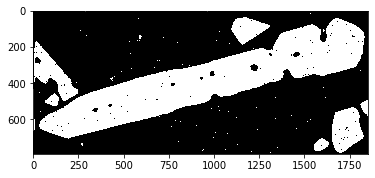

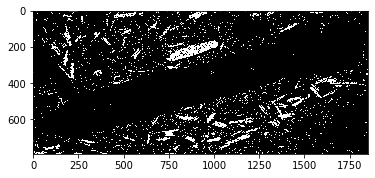

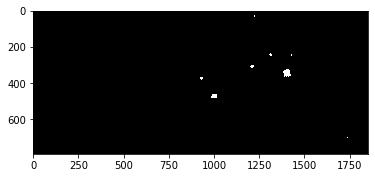

In [7]:
thresh = [0.26,0.3,0.36,0.18]
post_thresh = []

for n in range(len(phase_images)):
    img = phase_images[n].copy()
    
    img[img<thresh[n]] = 0
    img[img>thresh[n]] = 1
    
    post_thresh.append(img)
    
    fig, ax = plt.subplots()
    ax.imshow(img)

Further processing of the images is done using 'morphological transformations' (https://scikit-image.org/docs/dev/api/skimage.morphology.html) to get rid of noise present due to having phases of similar compositions - one of the limitations of using EDS only.
'Area_opening' operation gets rid of objects lower than a given size and so it is used to remove single pixels or very small clusters of pixels which can be attributed to noise.

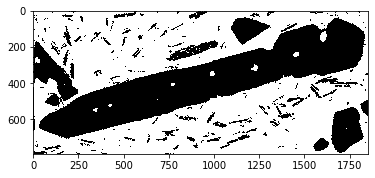

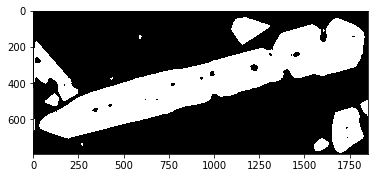

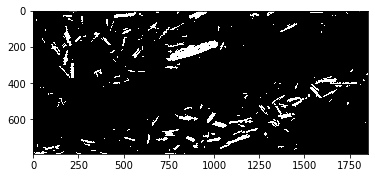

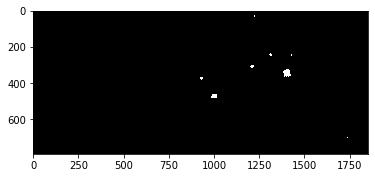

In [8]:
min_size = 10 #adjust this value or make into an array to give each mask an individual value
phase_mask = []

for n in range(len(post_thresh)):
    #if min_size is an array use min_size[n] below
    mask = morphology.area_opening(post_thresh[n], min_size)
    mask = morphology.area_closing(mask, min_size)
    phase_mask.append(mask)
    
    fig, ax = plt.subplots()
    ax.imshow(mask)

The above may be combined to give images like QEMSCAN of the different phases. Using the spectra plotted previously it is simple to identify phases:
0 - Glass,
1 - Olivine,
2 - Plagioclase,
3 - Cr-Spinel.

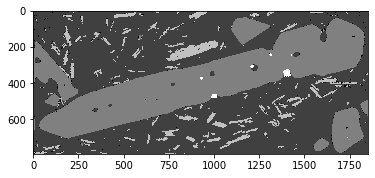

In [9]:
#create blank image - all zeroes
phase_map = np.zeros((len(phase_mask[0]), len(phase_mask[0][0])))
abundance = []

for i in range(len(phase_mask)):
    coords = np.nonzero(phase_mask[i])
    abundance.append(len(coords[0]))
    for n in range(len(coords[0])):
        phase_map[coords[0][n]][coords[1][n]] = i+1

#should show the phase map in grayscale
plt.imshow(phase_map)

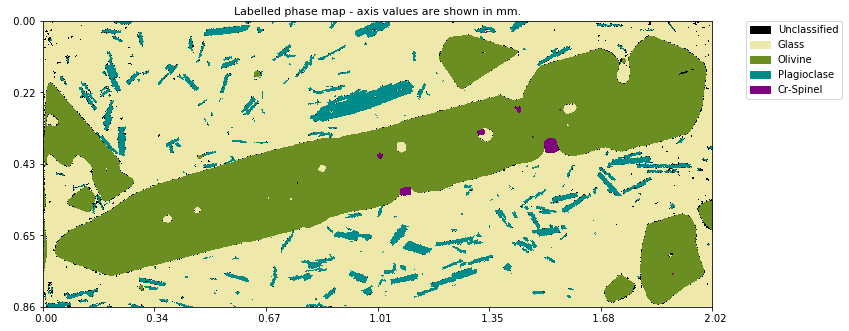

In [10]:
#replace with RGB codes for the desired colours
# index 0 is unclassified and the rest have to be in order of the phases in the above images from loadings
colour = ['black', 'palegoldenrod', 'olivedrab', 'darkcyan','purple' ]
cMap = ListedColormap(colour)

#create plot
fig, ax = plt.subplots(figsize = (12,24))
plot = plt.imshow(phase_map, cmap=cMap, interpolation = None)

#get values present in above image
values = np.unique(phase_map.ravel())

# get the colors of the values, according to the colormap used by imshow
colors = [ plot.cmap(plot.norm(value)) for value in values]

# Name each colour and create a patch (proxy artist) for every color 
phase_names = ["Unclassified", "Glass", "Olivine", "Plagioclase", "Cr-Spinel"]
patches = [ mpatches.Patch(color=colors[i], label=phase_names[i] ) for i in range(len(values)) ]

# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

#set tick marks here, including how many to show
x_ticks = np.linspace(0,len(phase_map[0]),7)
y_ticks = np.linspace(0,len(phase_map),5)

# What those pixel locations correspond to in data coordinates.
# Also set the float format here
x_ticklabels = ["{:6.2f}".format(i) for i in (x_ticks*data.axes_manager[0].scale)/1000]
y_ticklabels = ["{:6.2f}".format(i) for i in (y_ticks*data.axes_manager[0].scale)/1000]

#apply the above changes to the plot
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels)

plt.title("Labelled phase map - axis values are shown in mm.", fontsize = 11)
plt.show()

In [12]:
#to save above plot:
fig.savefig("name here", dpi = 600)

Modal Glass proportion: 0.6132025664077795
Modal Olivine proportion: 0.3273506873721878
Modal Plagioclase proportion: 0.05751293640323652
Modal Cr-Spinel proportion: 0.0019338098167962466


Text(0.5, 0.98, 'Modal phase proportions')

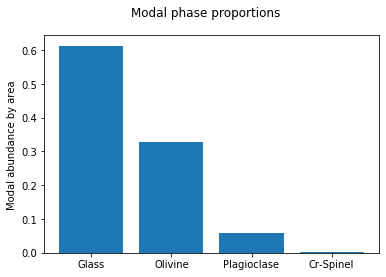

In [31]:
#omit first name (label = 0 - which is unclassified) so only real phase names are present
names = phase_names[1:].copy()

#measure phase proportions by area here
total_pix = sum(abundance)

phase_proportions = []
for i in range(len(abundance)):
    phase_proportions.append(abundance[i]/total_pix)
    print("Modal " + names[i] + " proportion: " + str(phase_proportions[i]))
    
fig, ax = plt.subplots()

x = range(len(abundance))
ax.bar(x, phase_proportions,tick_label = names)
ax.set_ylabel("Modal abundance by area")
fig.suptitle("Modal phase proportions")

## Textural Quantification

Using standard Data Analysis libraries - suck as skimage, it is possible to rapidly quantify crystal sizes and shapes from binary phase masks generated above. See the 'measure' module within skimage for more info - https://scikit-image.org/docs/dev/api/skimage.measure.html.

In this example the Plagioclase phase mask will be used to show how this may be done. The first step is to actually determine where the different crystals are within the phase mask and label them. A simple approach is to label by connectivity of pixels, however it assumes separate crystals are not touching and clusters can lead to significant errors. An image processing approach is to use marker based watershed segmentation to separate clusters; it can work well, but requires some manual tweaking. The algorithm is based on segmentation of touching circles - it doesn't perform as well with non circular objects. The smartest approach may be to use EBSD data to segment clusters based on contrast from crystallographic orientation.

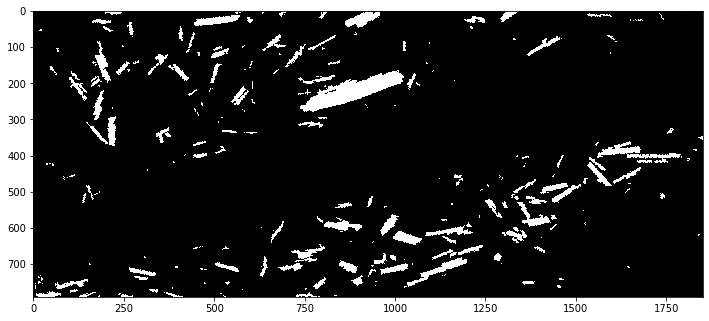

In [13]:
#filled objects are best to perform watershed as inclusions are treated as 'background' in binary mask so it may
#be worth filling in the crystals using morphological transformations to improve segmentation quality

plag_mask = phase_mask[2].copy()
plag_mask = morphology.area_closing(plag_mask, 30)

fig, ax = plt.subplots(figsize = (12,24))
ax.imshow(plag_mask)

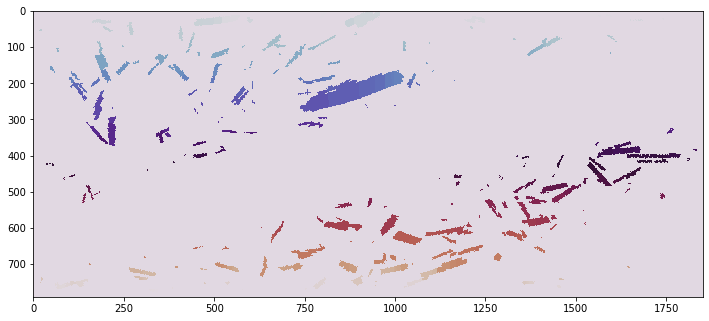

In [14]:
ws_mask = plag_mask.copy()

distance = ndi.distance_transform_edt(ws_mask)

#tune footprint to get wanted/optimum segmentation of touching objects?
#large objects may get oversegmented whilst smaller ones won't segment at all - it's impossible to get it perfect
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((25,25)), labels=ws_mask)

markers = ski.morphology.label(local_maxi, connectivity = 2)
labels_ws = ski.morphology.watershed(-distance, markers, mask=ws_mask)

fig, ax = plt.subplots(figsize = (12,24))
ax.imshow(labels_ws, cmap = 'twilight')

The function 'regioprops' from the measure module is the most useful function going forward, measuring crystal areas, aspect ratio (best fit ellipse major axis/minor axis), perimeter, convex hull area etc. It's relatively easy to plot approximate CSD's (as in Neave et. al. 2017) using some pre-written functions saved in the .py files. Note scale is stored in the original .bcf file and the .hspy file saved after NMF is done.

/home/norbert/Desktop/Summer 2020/Scripts/Approx_CSD_generators.py:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


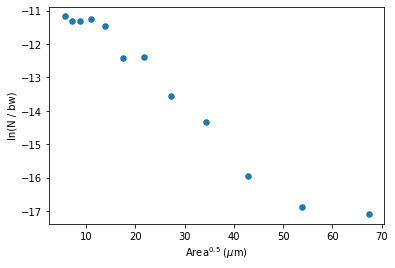

In [15]:
#get spatial resolution of individual pixels; the 0th axis is a spatial dimension so can be used here
#if it wasn't clear it's a spatial dimension it can be modified to: 
#scale = data.axes_manager.navigation_axes[0].scale
scale = data.axes_manager[0].scale


plag = labels_ws.copy()
properties = measure.regionprops(labels_ws)
ROI_area = scale**2 * len(plag)*len(plag[0])

#in the approximate CSD size is measure in Area^{0.5}
size = [np.sqrt(cryst.area) for cryst in properties]

#the function used to generate plot uses geometric binning
#it requires the following input: size, min_size, max_size - minimum and maximum to be used for binning
#n_bins - number of bins used
#scale - scale/spatial resolution of pixel
distribution, ax = csd.gen_csd_plot(size, 5,75,12,ROI_area)

Aspect ratios may also be plotted, either as a distribution or as a function of size.

Text(0, 0.5, 'Aspect Ratio')

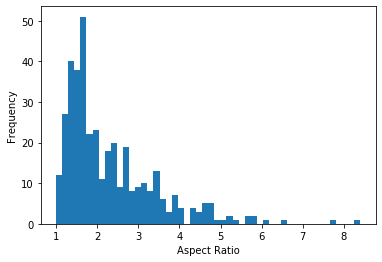

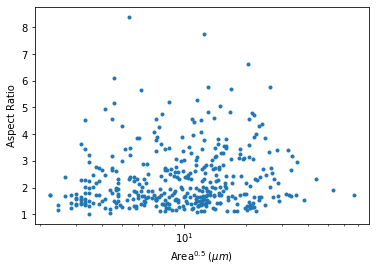

In [16]:
aspect_ratio = [cryst.major_axis_length/cryst.minor_axis_length for cryst in properties]
#can apply correction proposed by Neave et. al. (2017) to aspect ratios
#aspect_ratio_corr = [(1.150*item - 0.195) for item in aspect_ratio]

plt.hist(aspect_ratio, 50)
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")

fig, ax = plt.subplots()
ax.plot(size, aspect_ratio, '.')
ax.set_xscale('log')
ax.set_xlabel(r"Area$^{0.5}$ ($\mu m$)")
ax.set_ylabel("Aspect Ratio")

Further operations are also possible, such as establishing size-composition relationships but they are computationally very expensive so it's best to use the cluster and save the data in a binary file - eg .npz numpy binary, as done here.

In [17]:
#load and plot size-comp relationship

In [32]:
#orientation data

In [33]:
#area-perimeter relationships